In [1]:
# script only for paper figures

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from statannotations.Annotator import Annotator
from itertools import combinations

# Distances

In [2]:
msa_regions_pdbs = pd.read_csv('../datasets/msa_regions_pdbs.tsv', sep = '\t')
to_calculate = pd.read_csv('../datasets/to_calculate_distances.tsv', sep= '\t')
# This df contain the CRE positions in uniprot numbering
# comes from msas_mapping.ipynb script
all_shortest_distances_mapped = pd.read_csv('../datasets/all_shortest_distances_mapped.tsv', sep= '\t')
msa_pdb = to_calculate[['msa', 'pdb']].drop_duplicates()
# Add MSA info
all_shortest_distances_mapped = all_shortest_distances_mapped.merge(msa_pdb, how= 'left')

In [3]:
# Compare KD and CRE ranges to determine KD location in the sequences respect to CRE
# closed parameter 'neither' so not considering overlaps at the ends
kd_intervals = []
cre_intervals = []
for start, end in zip(to_calculate.start_kd, to_calculate.end_kd):
    kd_intervals.append(pd.Interval(start, end, closed= 'neither'))

for start, end in zip(to_calculate.start_cre, to_calculate.end_cre):
    cre_intervals.append(pd.Interval(start, end, closed= 'neither'))

# List with possible archithectures: n-ter, c-ter, within-kd
kd_location = []
for kd_inter, cre_inter in zip(kd_intervals, cre_intervals):

    if cre_inter.overlaps(kd_inter):

        if kd_inter.left <= cre_inter.left and kd_inter.right >= cre_inter.right:       # Check if CRE is completely within KD
            kd_location.append("within-kd")
        else:
            overlap_percentage = round(((min(kd_inter.right, cre_inter.right) - max(kd_inter.left, cre_inter.left)) +1) / ((cre_inter.right - cre_inter.left) +1)* 100)
            kd_location.append(f"overlaps-kd {overlap_percentage}%")

    elif kd_inter > cre_inter:
        kd_location.append("c-ter")

    elif kd_inter < cre_inter:
        kd_location.append("n-ter")
###
    else:
        print('error')

to_calculate["kd_location"] = kd_location

kd_location = to_calculate[['pdb', 'start_kd', 'end_kd', 'start_cre', 'end_cre', 'kd_location']].drop_duplicates()
all_shortest_distances_mapped = all_shortest_distances_mapped.merge(to_calculate[['pdb', 'kd_location']].drop_duplicates(), how= 'left')

In [4]:
# pos_cre_uniprot should be in cre_start, cre_end limits
cre_coord = to_calculate[['pdb', 'chain', 'start_cre', 'end_cre']].drop_duplicates()
cre_coord["pdb_chain"] = cre_coord.pdb + "_" + cre_coord.chain
cre_coord.drop(columns= ['pdb', 'chain'], inplace= True)

# Add the coords
all_shortest_distances_mapped = all_shortest_distances_mapped.merge(cre_coord, how= 'left')
# Subset it
subset_df = all_shortest_distances_mapped[(all_shortest_distances_mapped['pos_cre_uniprot'] >= all_shortest_distances_mapped['start_cre']) & (all_shortest_distances_mapped['pos_cre_uniprot'] <= all_shortest_distances_mapped['end_cre'])]

In [5]:
subset_df.pdb.nunique()

801

In [7]:
all_shortest_distances_mapped.pdb.nunique()

804

In [5]:
def plot_distances(msa_name, title, out= None):
    # Group by pdb col
    msa_df = subset_df[subset_df.msa == msa_name]

    # Create a new figure for each pdb
    plt.figure(figsize= (12,8), facecolor= 'white')

    fig = sns.lineplot(data= msa_df, x= 'pos_cre_uniprot', y= 'dist', hue= 'pdb_chain', linewidth = 3, alpha= 0.5)

    #plt.title(f"Interatomic distances in MSA {msa_df.msa.unique()[0]}\nKD location: {msa_df.kd_location.values[0]}")
    plt.title(title)
    plt.xlabel("CRE position")
    plt.ylabel("distance to KD (Å)")
    plt.rcParams['font.size'] = 22

    # # Set the x-axis limits as the minimun and max residue in the MSA
    # xmin = to_calculate[to_calculate.msa == msa].pdb_start_cre.min()
    # xmax = to_calculate[to_calculate.msa == msa].pdb_end_cre.max()
    # print(xmin, xmax)

    # plt.xlim([xmin, xmax])
    #plt.xlim(55, 245)
    plt.hlines(y= 6, xmin= plt.xlim()[0], xmax= plt.xlim()[1], colors= 'r', linestyles= "--")
    plt.legend(loc='best', prop={'size': 16}) # , bbox_to_anchor=(1.45, 0.5),
    #plt.legend().remove()
    plt.tight_layout()
    if out != None:
        plt.savefig(f'{out}.png', dpi= 300)
    plt.show()

### P00519_60

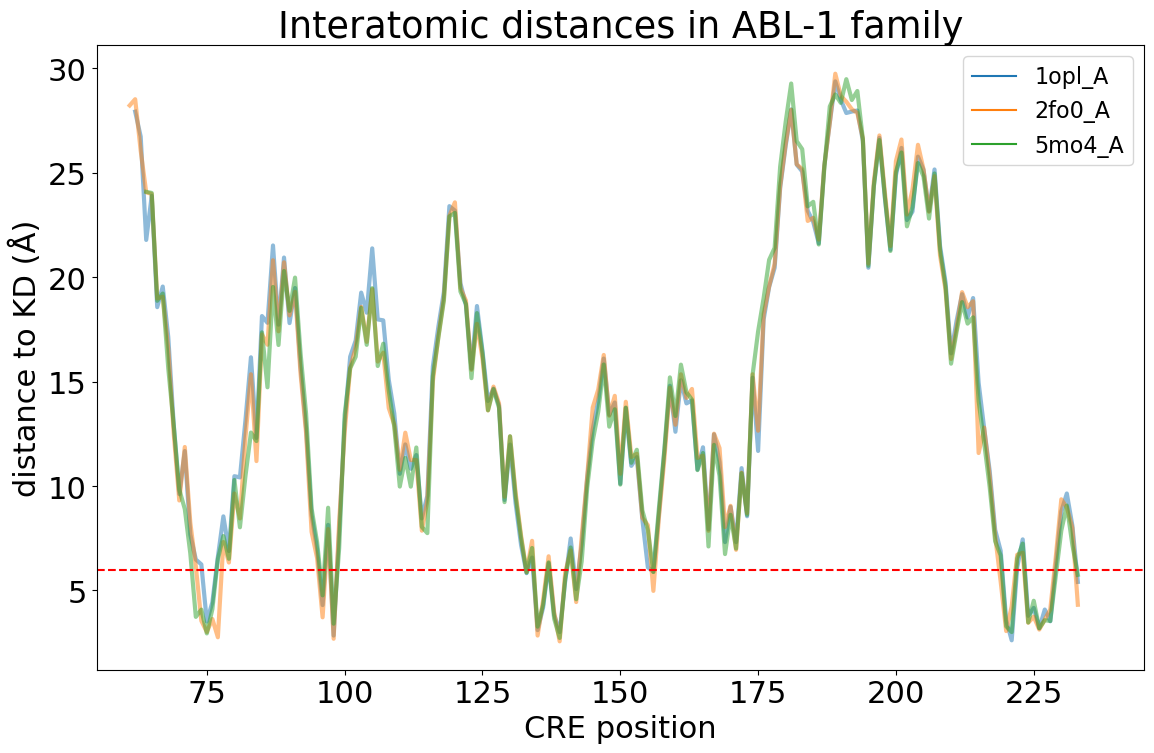

In [13]:
# Group by pdb col
P00519_60_df = subset_df[subset_df.msa == 'P00519_60']

# Keep PDBs that cover most of SH2 and SH3 domains
mask = P00519_60_df.groupby(['pdb_chain'])['pos_cre_uniprot'].min() < 100
mask = mask[mask].index
P00519_60_df = P00519_60_df[P00519_60_df.pdb_chain.isin(mask)]

# Smooth curve
x = P00519_60_df[['pdb_chain','pos_cre_uniprot', 'dist']].pos_cre_uniprot
y = P00519_60_df[['pdb_chain','pos_cre_uniprot', 'dist']].dist
smooth = interp1d(x= x, y= y) # , kind= 'cubic'
P00519_60_df["smooth_dist"] = smooth(x)

# Create a new figure for each pdb
plt.figure(figsize= (12,8), facecolor= 'white')

fig = sns.lineplot(data= P00519_60_df, x= 'pos_cre_uniprot', y= 'dist', hue= 'pdb_chain', linewidth = 3, alpha= 0.5)
#fig = sns.lineplot(data= P00519_60_df, x= 'pos_cre_uniprot', y= 'smooth_dist', hue= 'pdb_chain', linewidth = 1, alpha= 1)

#plt.title(f"Interatomic distances in MSA {P00519_60_df.msa.unique()[0]}\nKD location: {P00519_60_df.kd_location.values[0]}")
plt.title("Interatomic distances in ABL-1 family")
plt.xlabel("CRE position")
plt.ylabel("distance to KD (Å)")
plt.rcParams['font.size'] = 22

# # Set the x-axis limits as the minimun and max residue in the MSA
# xmin = to_calculate[to_calculate.msa == msa].pdb_start_cre.min()
# xmax = to_calculate[to_calculate.msa == msa].pdb_end_cre.max()
# print(xmin, xmax)

# plt.xlim([xmin, xmax])
plt.xlim(55, 245)
plt.hlines(y= 6, xmin= plt.xlim()[0], xmax= plt.xlim()[1], colors= 'r', linestyles= "--")
plt.legend(loc='best', prop={'size': 16}) # , bbox_to_anchor=(1.45, 0.5),
#plt.legend().remove()
plt.tight_layout()
#plt.savefig('../plots/paper/interatomic_distances_abl1.png', dpi= 300)
plt.show()

In [37]:
subset_df[subset_df.msa == 'P00519_60'].pdb_chain.unique()

array(['1opl_A', '2e2b_A', '2f4j_A', '2fo0_A', '2g1t_A', '2g2f_A',
       '2g2h_A', '2g2i_A', '2gqg_A', '2hiw_A', '2hz0_A', '2hzi_A',
       '2v7a_A', '3cs9_A', '3pyy_A', '3qri_A', '3qrk_A', '3ue4_A',
       '4xey_A', '4yc8_A', '4zog_A', '5hu9_A', '5mo4_A', '6bl8_A',
       '6npe_A', '6npu_A', '6npv_A', '6xr6_A', '6xr7_A', '6xrg_A',
       '7cc2_A', '7dt2_A', '7n9g_A', '7w7x_A', '7w7x_B', '7w7y_A',
       '7w7y_B'], dtype=object)

In [43]:
abl1_family_pdbs_sorted = to_calculate[to_calculate.msa == "P00519_60"][['pdb', 'pdb_start_cre', 'pdb_end_cre', 'pdb_start_kd', 'pdb_end_kd']].drop_duplicates().sort_values('pdb_start_kd')
abl1_family_pdbs_sorted["model"]

,pdb,pdb_start_cre,pdb_end_cre,pdb_start_kd,pdb_end_kd
76,3qrj,234,252,242,493
59,3cs9,233,233,242,493
58,7cc2,233,233,242,493
57,2g2f,232,233,242,493
65,6bl8,233,233,242,493
75,2hyy,235,252,242,493
66,2v7a,233,233,242,493
67,4twp,233,233,242,493
68,4zog,233,233,242,493
49,3qrk,229,233,242,493


In [45]:
abl1_family_pdbs_sorted.pdb.nunique()

39

In [44]:
with open('../datasets/abl1_family_pdbs.txt', "w") as f:
    for i in abl1_family_pdbs_sorted.pdb.unique():
        f.write(i + " ")

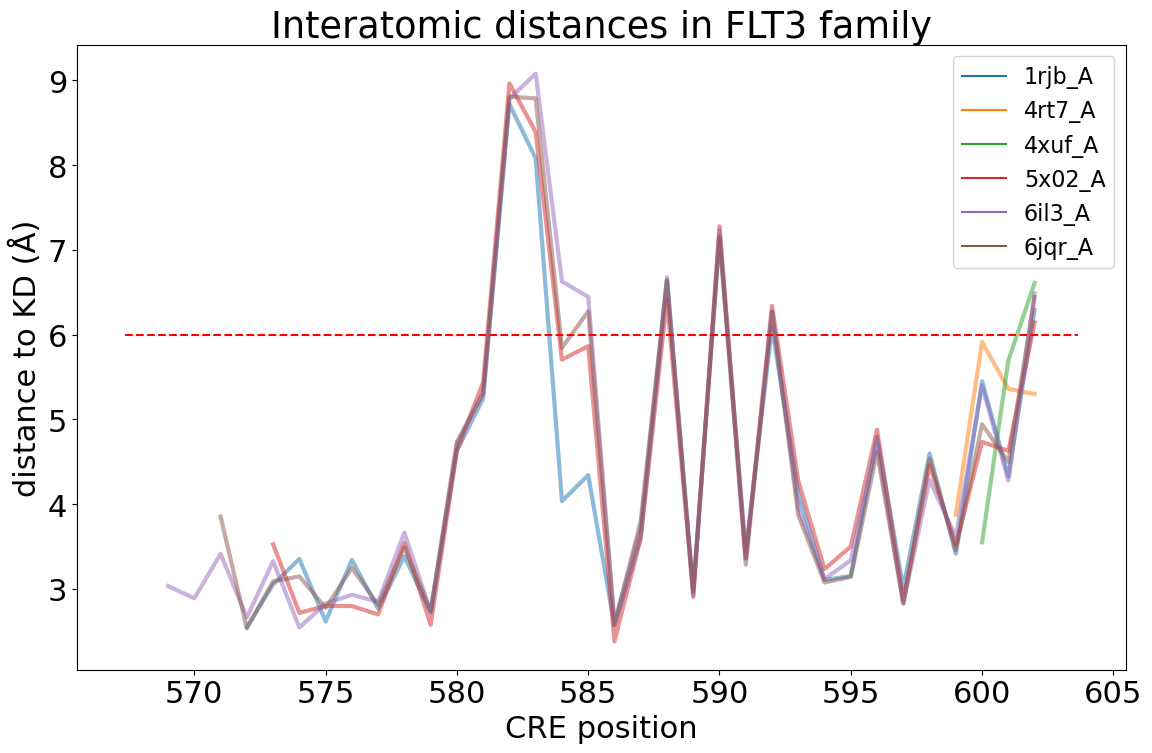

In [12]:
plot_distances(msa_name= "P36888_60", title= "Interatomic distances in FLT3 family", out= '../plots/paper/flt3_distances_plot')

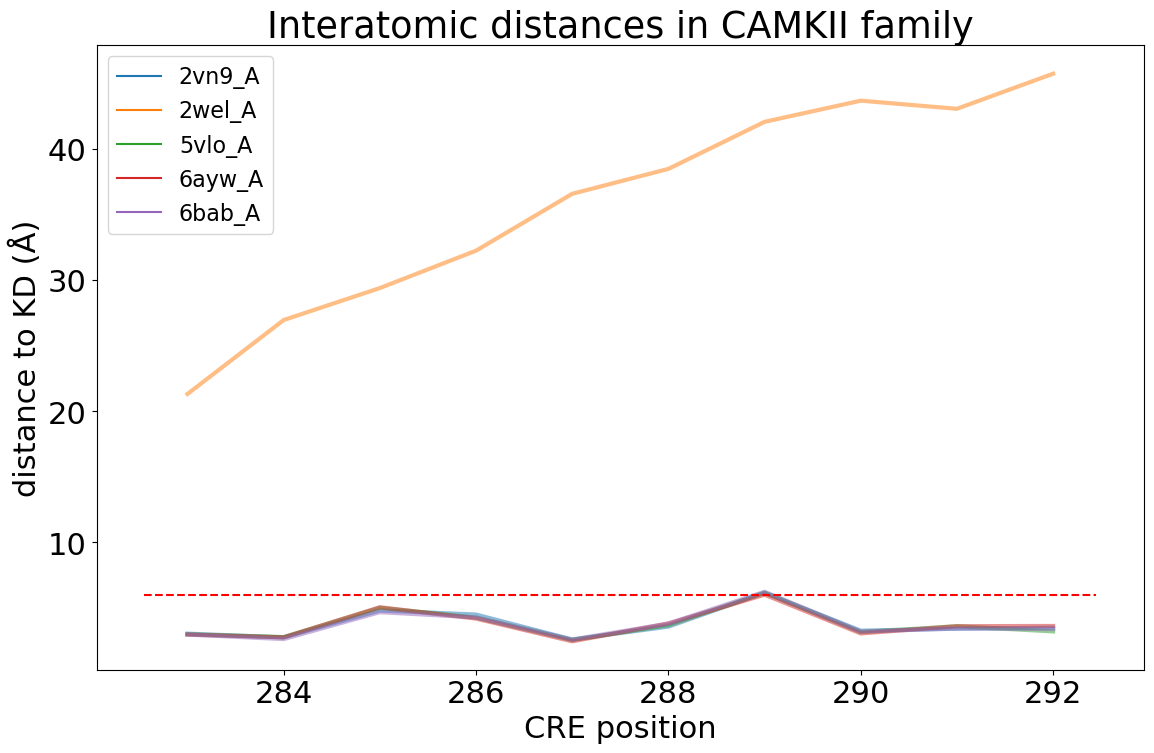

In [8]:
plot_distances(msa_name= "Q13557_60", title= "Interatomic distances in CAMKII family", out= '../plots/paper/camkii_distances_plot')

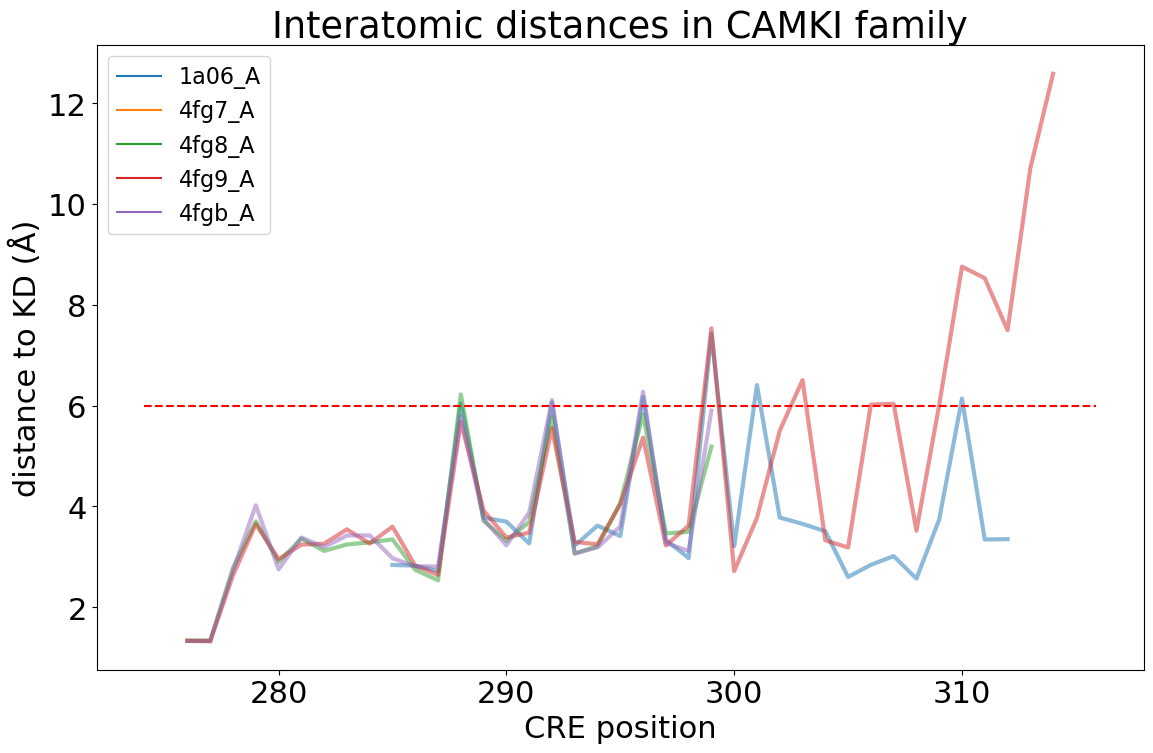

In [7]:
plot_distances(msa_name= "Q91YS8_60", title= "Interatomic distances in CAMKI family", out= '../plots/paper/camki_distances_plot')

# distances by feature

### Datasets

In [6]:
interpro_binding_sites = pd.read_csv('../datasets/interpro_binding_sites.tsv', sep= '\t')
# lower
interpro_binding_sites.entry_type = interpro_binding_sites.entry_type.str.lower()
# keep the entry_name after ","
interpro_binding_sites.entry_name = interpro_binding_sites.entry_name.apply(lambda x: x.split(",")[1])
interpro_binding_sites.entry_name = interpro_binding_sites.entry_name.apply(lambda x: x.strip())

In [26]:
# The EF hand is a helix–loop–helix structural domain or motif found in a large family of calcium-binding proteins
#interpro_binding_sites.entry_name.value_counts() 

In [7]:
# Add MSAs info
msas = pd.read_csv('../datasets/all_msas.tsv', sep= '\t')
msas = msas[msas.msa.str.endswith("60")]
msas = msas.rename(columns= {'uniprot': 'uniprot_acc'})
interpro_binding_sites = interpro_binding_sites.merge(msas, how= 'left')
interpro_binding_sites = interpro_binding_sites[['msa', 'uniprot_acc', 'ipr_acc', 'start', 'end', 'entry_type', 'entry_name']]

In [8]:
shortest_distances = all_shortest_distances_mapped[['msa', 'pdb', 'pos_kd', 'aa_a', 'atom_a', 'pos_cre', 'aa_b', 'atom_b', 'dist']]

In [9]:
# Mapping MSA-UniProt-PDB
msa_uniprot_pdb = msa_regions_pdbs[['msa', 'uniprot', 'pdb']].drop_duplicates()

In [21]:
def expand_rows(row):
    '''
    Function to create new rows for each range of 'start' to 'end'
    '''
    return pd.DataFrame({'msa': row['msa'],
                         'uniprot_acc': row['uniprot_acc'],
                         'ipr_acc': row['ipr_acc'],
                         'start': range(row['start'], row['end'] + 1),
                         #'end': range(row['start'] + 1, row['end'] + 2),
                         'entry_type': row['entry_type'],
                         'entry_name': row['entry_name']})

In [22]:
# First, group by MSA
distances_P00519_60 = shortest_distances[shortest_distances.msa == 'P00519_60']
# Second, binding sites for that MSA
binding_sites = interpro_binding_sites[interpro_binding_sites.msa == 'P00519_60']
# Apply the function to each row of the Binding sites ranges
expanded_rows = binding_sites.apply(expand_rows, axis=1) # binding_sites is a subset grouped by MSA
# Concatenate the expanded rows
result_df = pd.concat(expanded_rows.values, ignore_index=True) # Ok!
result_df = result_df.drop(columns= ['entry_type']).rename(columns= {'start': 'pos'})

# Add uniprot to the distances
distances_P00519_60 = distances_P00519_60.merge(msa_uniprot_pdb, how= 'left')
distances_P00519_60 = distances_P00519_60.rename(columns= {'uniprot': 'uniprot_acc'})
# Add distance ID
distances_P00519_60["id_distance"] = range(1, distances_P00519_60.shape[0]+1)

# Check in KD and CRE positions
merge_kd = result_df.merge(distances_P00519_60, left_on= ['msa', 'uniprot_acc', 'pos'], right_on= ['msa', 'uniprot_acc', 'pos_kd'])
merge_cre = result_df.merge(distances_P00519_60, left_on= ['msa', 'uniprot_acc', 'pos'], right_on= ['msa', 'uniprot_acc', 'pos_cre'])

# Concat both tables and drop duplicates (?)
binding_sites_distances = pd.concat([merge_kd, merge_cre]).drop_duplicates()

# Drop cases where pos_kd = pos_cre
binding_sites_distances = binding_sites_distances[binding_sites_distances.pos_kd != binding_sites_distances.pos_cre]

# Now a df with all distances
to_concat = binding_sites_distances[['msa', 'uniprot_acc', 'pdb', 'pos', 'entry_name', 'pos_kd',
       'aa_a', 'atom_a', 'pos_cre', 'aa_b', 'atom_b', 'dist', 'id_distance']]
# rest is distances that has no binding site annotation
rest = distances_P00519_60[~distances_P00519_60.id_distance.isin(binding_sites_distances.id_distance)]
rest["entry_name"] = 'rest'
rest["pos"] = 0 # arbitrary

df = pd.concat([to_concat, rest])

/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Plots

In [42]:
def plot_distances_feature(msa_name, title, out= None):
       # First, group by MSA
       distances_msa = shortest_distances[shortest_distances.msa == msa_name]
       # Second, binding sites for that MSA
       binding_sites = interpro_binding_sites[interpro_binding_sites.msa == msa_name]
       # Apply the function to each row of the Binding sites ranges
       expanded_rows = binding_sites.apply(expand_rows, axis=1) # binding_sites is a subset grouped by MSA
       # Concatenate the expanded rows
       result_df = pd.concat(expanded_rows.values, ignore_index=True) # Ok!
       result_df = result_df.drop(columns= ['entry_type']).rename(columns= {'start': 'pos'})

       # Add uniprot to the distances
       distances_msa = distances_msa.merge(msa_uniprot_pdb, how= 'left')
       distances_msa = distances_msa.rename(columns= {'uniprot': 'uniprot_acc'})
       # Add distance ID
       distances_msa["id_distance"] = range(1, distances_msa.shape[0]+1)

       # Check in KD and CRE positions
       merge_kd = result_df.merge(distances_msa, left_on= ['msa', 'uniprot_acc', 'pos'], right_on= ['msa', 'uniprot_acc', 'pos_kd'])
       merge_cre = result_df.merge(distances_msa, left_on= ['msa', 'uniprot_acc', 'pos'], right_on= ['msa', 'uniprot_acc', 'pos_cre'])

       # Concat both tables and drop duplicates (?)
       binding_sites_distances = pd.concat([merge_kd, merge_cre]).drop_duplicates()

       # Drop cases where pos_kd = pos_cre
       binding_sites_distances = binding_sites_distances[binding_sites_distances.pos_kd != binding_sites_distances.pos_cre]

       # Now a df with all distances
       to_concat = binding_sites_distances[['msa', 'uniprot_acc', 'pdb', 'pos', 'entry_name', 'pos_kd',
              'aa_a', 'atom_a', 'pos_cre', 'aa_b', 'atom_b', 'dist', 'id_distance']]
       # rest is distances that has no binding site annotation
       rest = distances_msa[~distances_msa.id_distance.isin(binding_sites_distances.id_distance)]
       rest["entry_name"] = 'rest'
       rest["pos"] = 0 # arbitrary

       df = pd.concat([to_concat, rest])
       return df
       # # Create a new figure
       # plt.figure(figsize= (10,10), facecolor= 'white')

       # sns.set(rc={'figure.figsize':(12, 8)}, font_scale= 2, style= 'white')

       # order = sorted(df.entry_name.value_counts().index.to_list())
       # colors= ['#ef476f', '#ffd166', '#26547c', '#06d6a0']

       # if order == ['active site', 'ATP binding site', 'rest']:
       #        colors= ['#ef476f', '#ffd166', '#26547c', '#06d6a0']
       # elif order == ['active site', 'rest']:
       #        colors= ['#ef476f', '#26547c']
       # elif order == ['ATP binding site', 'rest']:
       #        colors = ['#ffd166', '#26547c']


       # flierprops = dict(marker='o', markerfacecolor='gray', markersize= 5,  markeredgecolor='black')
       # ax = sns.boxplot(data= df, x= 'entry_name', y= 'dist', order= order, width= 0.45, linewidth= 3, medianprops=dict(color="gray", alpha=0.9), palette= colors, flierprops= flierprops) # order= ['rest', ],  , notch= True , showmeans= True, meanline= True

       # # Combinations to compare
       # comb = combinations(df.entry_name.unique(), 2)
       # pairs = [ i for i in comb ]

       # annotator = Annotator(ax= ax, pairs= pairs, data= df, x= 'entry_name', y= 'dist')
       # annotator.configure(test= 'Mann-Whitney', text_format='star')
       # annotator.apply_and_annotate()

       # sns.despine(fig=None, ax= ax, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

       # #plt.rcParams['font.size'] = 16
       # plt.title(title) # f" in {msa}
       # plt.ylabel("distance (Å)")
       # plt.xlabel("")
       # #plt.legend(loc= 1,  bbox_to_anchor=(1.05, 1)) # ,  bbox_to_anchor=(1.25, 1)
       # plt.tight_layout()
       # if out != None:
       #        plt.savefig(f'{out}.png', dpi= 300)
       # plt.show()

/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ATP binding site vs. active site: Mann-Whitney-Wilcoxon test two-sided, P_val:6.646e-01 U_stat=1.755e+04
active site vs. rest: Mann-Whitney-Wilcoxon test two-sided, P_val:2.387e-01 U_stat=2.686e+04
ATP binding site vs. rest: Mann-Whitney-Wilcoxon test two-sided, P_val:6.828e-03 U_stat=1.488e+05


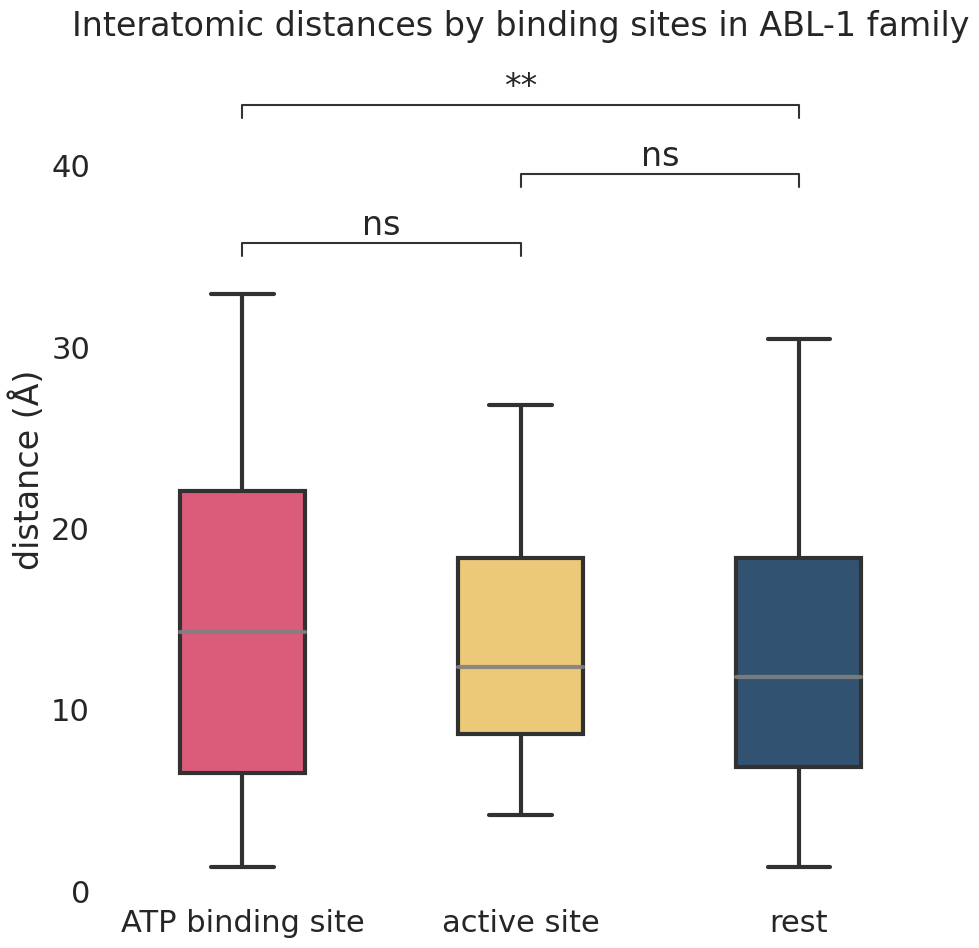

In [35]:
plot_distances_feature(msa_name= "P00519_60", title= "Interatomic distances by binding sites in ABL-1 family", out= '../plots/paper/abl1_distances_by_feature')

/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

active site vs. rest: Mann-Whitney-Wilcoxon test two-sided, P_val:8.223e-04 U_stat=3.410e+02


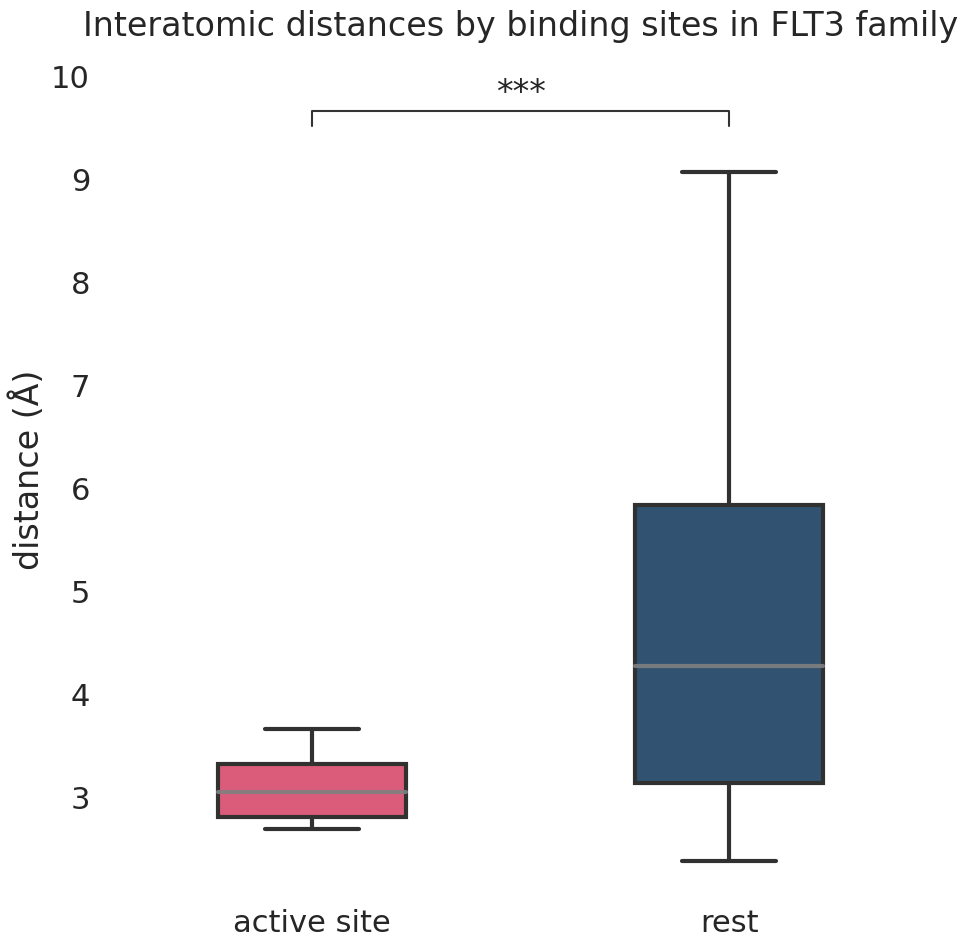

In [31]:
plot_distances_feature(msa_name= "P36888_60", title= "Interatomic distances by binding sites in FLT3 family", out= '../plots/paper/flt3_distances_by_feature')

/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ATP binding site vs. rest: Mann-Whitney-Wilcoxon test two-sided, P_val:7.066e-01 U_stat=4.000e+02


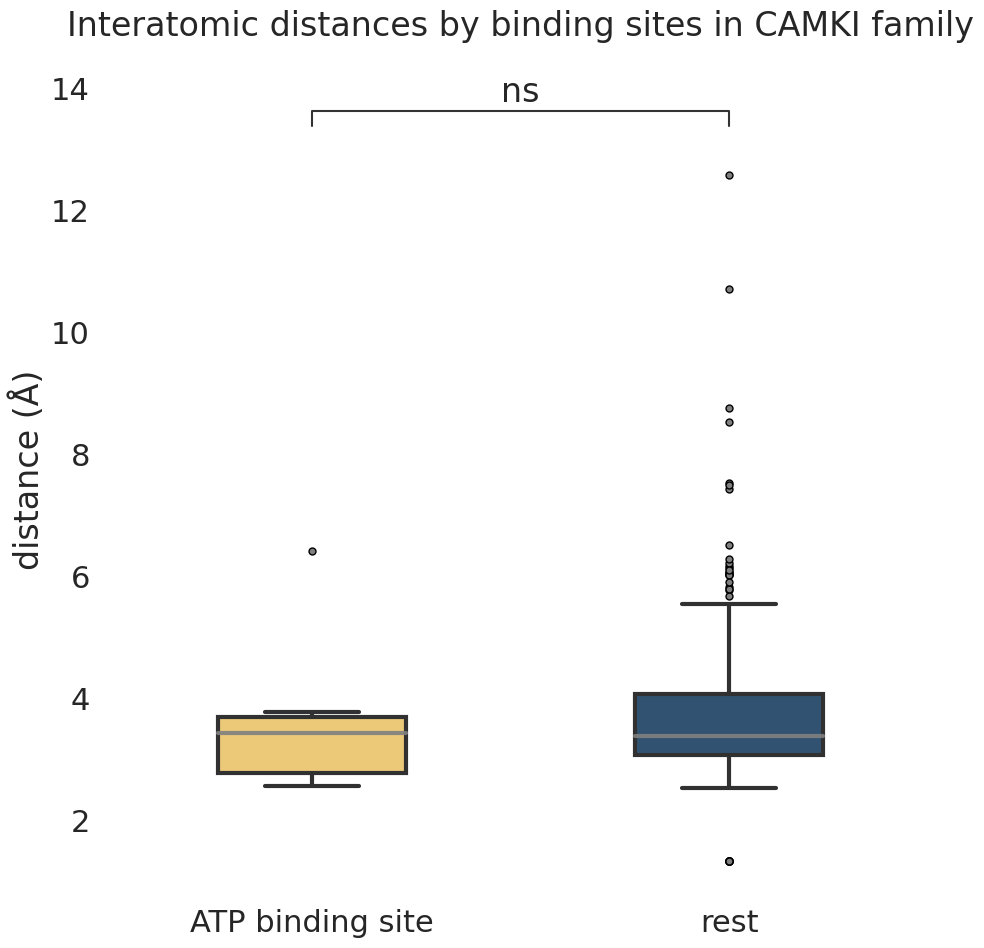

In [24]:
plot_distances_feature(msa_name= "Q91YS8_60", title= "Interatomic distances by binding sites in CAMKI family", out= '../plots/paper/camki_distances_by_feature')

In [43]:
plot_distances_feature(msa_name= "Q13557_60", title= "Interatomic distances by binding sites in CAMKII family", out= '../plots/paper/camkii_distances_by_feature')

,msa,uniprot_acc,pdb,pos,entry_name,pos_kd,aa_a,atom_a,pos_cre,aa_b,atom_b,dist,id_distance
0,Q13557_60,Q13557,2vn9,0,rest,108,TYR,N,283,HIS,ND1,3.032140,1
1,Q13557_60,Q13557,2vn9,0,rest,237,GLU,O,284,ARG,NH2,2.747996,2
2,Q13557_60,Q13557,2vn9,0,rest,106,GLU,O,285,GLN,OE1,4.799066,3
3,Q13557_60,Q13557,2vn9,0,rest,209,VAL,O,286,GLU,O,4.487375,4
4,Q13557_60,Q13557,2vn9,0,rest,208,LEU,O,287,THR,OG1,2.581363,5
5,Q13557_60,Q13557,2vn9,0,rest,103,VAL,O,288,VAL,CG1,3.567297,6
6,Q13557_60,Q13557,2vn9,0,rest,103,VAL,CG1,289,ASP,N,6.148854,7
7,Q13557_60,Q13557,2vn9,0,rest,210,GLY,O,290,CYS,O,3.256594,8
8,Q13557_60,Q13557,2vn9,0,rest,102,ILE,CG2,291,LEU,CD1,3.407484,9
9,Q13557_60,Q13557,2vn9,0,rest,103,VAL,CG1,292,LYS,N,3.486277,10


In [36]:
shortest_distances[shortest_distances.msa == "Q13557_60"]

,msa,pdb,pos_kd,aa_a,atom_a,pos_cre,aa_b,atom_b,dist
6458,Q13557_60,2vn9,108,TYR,N,283,HIS,ND1,3.032140
6459,Q13557_60,2vn9,237,GLU,O,284,ARG,NH2,2.747996
6460,Q13557_60,2vn9,106,GLU,O,285,GLN,OE1,4.799066
6461,Q13557_60,2vn9,209,VAL,O,286,GLU,O,4.487375
6462,Q13557_60,2vn9,208,LEU,O,287,THR,OG1,2.581363
6463,Q13557_60,2vn9,103,VAL,O,288,VAL,CG1,3.567297
6464,Q13557_60,2vn9,103,VAL,CG1,289,ASP,N,6.148854
6465,Q13557_60,2vn9,210,GLY,O,290,CYS,O,3.256594
6466,Q13557_60,2vn9,102,ILE,CG2,291,LEU,CD1,3.407484
6467,Q13557_60,2vn9,103,VAL,CG1,292,LYS,N,3.486277


In [44]:
interpro_binding_sites[interpro_binding_sites.msa == "Q13557_60"]#.entry_name.value_counts()

,msa,uniprot_acc,ipr_acc,start,end,entry_type,entry_name
1674,Q13557_60,A0A0D9QUX4,IPR008271,132,144,active_site,active site
1683,Q13557_60,A0A2K5DH32,IPR008271,132,144,active_site,active site
1688,Q13557_60,A0A2K5IMG1,IPR008271,132,144,active_site,active site
1693,Q13557_60,A0A2K5MK58,IPR008271,132,144,active_site,active site
1698,Q13557_60,A0A2K5XAA6,IPR008271,40,52,active_site,active site
...,...,...,...,...,...,...,...
17754,Q13557_60,Q6DEH3,IPR017441,19,42,binding_site,ATP binding site
17755,Q13557_60,Q6PHZ2,IPR017441,20,43,binding_site,ATP binding site
17757,Q13557_60,Q8CCM0,IPR017441,20,43,binding_site,ATP binding site
17759,Q13557_60,Q95266,IPR017441,20,43,binding_site,ATP binding site


# Disorder

### Datasets

In [11]:
# This dataset contains the CRE annotation in all the ortholog sequences
region_to_transfer = pd.read_csv('../homology_transfer/pipeline_MSA_uniprot/data_snake/12_region_to_transfer.txt', sep= " ")
region_to_transfer = region_to_transfer[(region_to_transfer.full_identity == '60') & (region_to_transfer.region_identity == '60')]

In [12]:
# df with cre coordinates in all orthologs
refer_coordinates = region_to_transfer[['ref_uniprot_acc', 'term_id', 'ref_start', 'ref_end']].drop_duplicates()
refer_coordinates = refer_coordinates[refer_coordinates.term_id.str.startswith("cre")]
refer_coordinates["is_reference"] = True
refer_coordinates = refer_coordinates.rename(columns= {'ref_uniprot_acc': 'uniprot_acc', 'ref_start': 'start', 'ref_end': 'end'})

# df with all proteins coordinates
ortho_coordinates = region_to_transfer[['uniprot_acc', 'term_id', 'start', 'end']].drop_duplicates()
#ortho_coordinates = ortho_coordinates[ortho_coordinates.term_id.str.startswith("cre")] # this is for include only the CRE in the analysis
ortho_coordinates["is_reference"] = False

cre_coordinates = pd.concat([refer_coordinates, ortho_coordinates])

In [13]:
cre_coordinates.uniprot_acc.nunique()

8405

In [14]:
mobidb_lite = pd.read_csv('../datasets/mobidb_lite_orthologs.tsv', sep= '\t')
mobidb_lite = mobidb_lite.drop(columns= 'Unnamed: 0')
# When nans is because mobidb doesn't have information of disorder for that entry
mobidb_lite = mobidb_lite[['acc', 'prediction_disorder_mobidb_lite']].dropna()#.explode("prediction_disorder_mobidb_lite")
# The col data must be dict
mobidb_lite.prediction_disorder_mobidb_lite = mobidb_lite.prediction_disorder_mobidb_lite.apply(lambda x: eval(x))
# Turn the dict into columns in the dataframe. Extract the keys from the first row's dictionary
keys = mobidb_lite['prediction_disorder_mobidb_lite'].iloc[0].keys()
# Create new columns for each key in the DataFrame
for key in keys:
    mobidb_lite[key] = mobidb_lite['prediction_disorder_mobidb_lite'].apply(lambda x: x.get(key, None))
mobidb_lite = mobidb_lite.rename(columns= {'acc': 'uniprot_acc'})

In [15]:
# Add CRE and KD coordinates
mobidb_lite_cre = mobidb_lite.merge(cre_coordinates, how= 'left')
mobidb_lite_cre

,uniprot_acc,prediction_disorder_mobidb_lite,regions,content_count,content_fraction,scores,term_id,start,end,is_reference
0,A0A026WPW6,"{'regions': [[1, 24], [84, 103], [357, 412]], ...","[[1, 24], [84, 103], [357, 412]]",100,0.243,"[1, 0.75, 0.75, 1, 0.75, 0.875, 0.875, 1, 1, 1...",kd12,29.0,311.0,False
1,A0A026WPW6,"{'regions': [[1, 24], [84, 103], [357, 412]], ...","[[1, 24], [84, 103], [357, 412]]",100,0.243,"[1, 0.75, 0.75, 1, 0.75, 0.875, 0.875, 1, 1, 1...",kd272,29.0,311.0,False
2,A0A096LS66,"{'regions': [[331, 363]], 'content_count': 33,...","[[331, 363]]",33,0.091,"[0.625, 0.75, 0.75, 0.75, 0.5, 0.375, 0.25, 0....",kd233,18.0,280.0,False
3,A0A096LS66,"{'regions': [[331, 363]], 'content_count': 33,...","[[331, 363]]",33,0.091,"[0.625, 0.75, 0.75, 0.75, 0.5, 0.375, 0.25, 0....",cre233,287.0,296.0,False
4,A0A096LS66,"{'regions': [[331, 363]], 'content_count': 33,...","[[331, 363]]",33,0.091,"[0.625, 0.75, 0.75, 0.75, 0.5, 0.375, 0.25, 0....",kd273,18.0,280.0,False
...,...,...,...,...,...,...,...,...,...,...
18719,H2PJU2,"{'regions': [[301, 338], [354, 391], [443, 486...","[[301, 338], [354, 391], [443, 486]]",120,0.198,"[0.875, 0.875, 0.875, 0.875, 0.75, 0.75, 0.875...",kd19,36.0,291.0,False
18720,H2PJU2,"{'regions': [[301, 338], [354, 391], [443, 486...","[[301, 338], [354, 391], [443, 486]]",120,0.198,"[0.875, 0.875, 0.875, 0.875, 0.75, 0.75, 0.875...",cre179,1.0,22.0,False
18721,H2PJU2,"{'regions': [[301, 338], [354, 391], [443, 486...","[[301, 338], [354, 391], [443, 486]]",120,0.198,"[0.875, 0.875, 0.875, 0.875, 0.75, 0.75, 0.875...",kd179,36.0,291.0,False
18722,V7B5Z3,"{'regions': [[16, 35]], 'content_count': 20, '...","[[16, 35]]",20,0.038,"[0.75, 0.75, 0.625, 0.5, 0.5, 0.625, 0.5, 0.37...",kd234,57.0,315.0,False


In [16]:
# Keep proteins with annotated CRE only
mobidb_lite_cre = mobidb_lite_cre[mobidb_lite_cre.term_id.notna()]#.uniprot_acc.nunique() # 6612 unique uniprot
# As int columns
mobidb_lite_cre.start = mobidb_lite_cre.start.apply(int)
mobidb_lite_cre.end = mobidb_lite_cre.end.apply(int)
mobidb_lite_cre

/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,uniprot_acc,prediction_disorder_mobidb_lite,regions,content_count,content_fraction,scores,term_id,start,end,is_reference
0,A0A026WPW6,"{'regions': [[1, 24], [84, 103], [357, 412]], ...","[[1, 24], [84, 103], [357, 412]]",100,0.243,"[1, 0.75, 0.75, 1, 0.75, 0.875, 0.875, 1, 1, 1...",kd12,29,311,False
1,A0A026WPW6,"{'regions': [[1, 24], [84, 103], [357, 412]], ...","[[1, 24], [84, 103], [357, 412]]",100,0.243,"[1, 0.75, 0.75, 1, 0.75, 0.875, 0.875, 1, 1, 1...",kd272,29,311,False
2,A0A096LS66,"{'regions': [[331, 363]], 'content_count': 33,...","[[331, 363]]",33,0.091,"[0.625, 0.75, 0.75, 0.75, 0.5, 0.375, 0.25, 0....",kd233,18,280,False
3,A0A096LS66,"{'regions': [[331, 363]], 'content_count': 33,...","[[331, 363]]",33,0.091,"[0.625, 0.75, 0.75, 0.75, 0.5, 0.375, 0.25, 0....",cre233,287,296,False
4,A0A096LS66,"{'regions': [[331, 363]], 'content_count': 33,...","[[331, 363]]",33,0.091,"[0.625, 0.75, 0.75, 0.75, 0.5, 0.375, 0.25, 0....",kd273,18,280,False
...,...,...,...,...,...,...,...,...,...,...
18719,H2PJU2,"{'regions': [[301, 338], [354, 391], [443, 486...","[[301, 338], [354, 391], [443, 486]]",120,0.198,"[0.875, 0.875, 0.875, 0.875, 0.75, 0.75, 0.875...",kd19,36,291,False
18720,H2PJU2,"{'regions': [[301, 338], [354, 391], [443, 486...","[[301, 338], [354, 391], [443, 486]]",120,0.198,"[0.875, 0.875, 0.875, 0.875, 0.75, 0.75, 0.875...",cre179,1,22,False
18721,H2PJU2,"{'regions': [[301, 338], [354, 391], [443, 486...","[[301, 338], [354, 391], [443, 486]]",120,0.198,"[0.875, 0.875, 0.875, 0.875, 0.75, 0.75, 0.875...",kd179,36,291,False
18722,V7B5Z3,"{'regions': [[16, 35]], 'content_count': 20, '...","[[16, 35]]",20,0.038,"[0.75, 0.75, 0.625, 0.5, 0.5, 0.625, 0.5, 0.37...",kd234,57,315,False


In [17]:
# Add MSAs info
all_msas = pd.read_csv('../datasets/all_msas.tsv', sep= '\t')
all_msas = all_msas[all_msas.msa.str.endswith("_60")]
mobidb_lite_cre_msa = mobidb_lite_cre.merge(all_msas[['msa', 'uniprot']].rename(columns= {'uniprot': 'uniprot_acc'}), how= 'left')
mobidb_lite_cre_msa

,uniprot_acc,prediction_disorder_mobidb_lite,regions,content_count,content_fraction,scores,term_id,start,end,is_reference,msa
0,A0A026WPW6,"{'regions': [[1, 24], [84, 103], [357, 412]], ...","[[1, 24], [84, 103], [357, 412]]",100,0.243,"[1, 0.75, 0.75, 1, 0.75, 0.875, 0.875, 1, 1, 1...",kd12,29,311,False,A8X6H4_60
1,A0A026WPW6,"{'regions': [[1, 24], [84, 103], [357, 412]], ...","[[1, 24], [84, 103], [357, 412]]",100,0.243,"[1, 0.75, 0.75, 1, 0.75, 0.875, 0.875, 1, 1, 1...",kd12,29,311,False,Q9TXJ0_60
2,A0A026WPW6,"{'regions': [[1, 24], [84, 103], [357, 412]], ...","[[1, 24], [84, 103], [357, 412]]",100,0.243,"[1, 0.75, 0.75, 1, 0.75, 0.875, 0.875, 1, 1, 1...",kd272,29,311,False,A8X6H4_60
3,A0A026WPW6,"{'regions': [[1, 24], [84, 103], [357, 412]], ...","[[1, 24], [84, 103], [357, 412]]",100,0.243,"[1, 0.75, 0.75, 1, 0.75, 0.875, 0.875, 1, 1, 1...",kd272,29,311,False,Q9TXJ0_60
4,A0A096LS66,"{'regions': [[331, 363]], 'content_count': 33,...","[[331, 363]]",33,0.091,"[0.625, 0.75, 0.75, 0.75, 0.5, 0.375, 0.25, 0....",kd233,18,280,False,Q8VDF3_60
...,...,...,...,...,...,...,...,...,...,...,...
39594,H2PJU2,"{'regions': [[301, 338], [354, 391], [443, 486...","[[301, 338], [354, 391], [443, 486]]",120,0.198,"[0.875, 0.875, 0.875, 0.875, 0.75, 0.75, 0.875...",cre179,1,22,False,Q62073_60
39595,H2PJU2,"{'regions': [[301, 338], [354, 391], [443, 486...","[[301, 338], [354, 391], [443, 486]]",120,0.198,"[0.875, 0.875, 0.875, 0.875, 0.75, 0.75, 0.875...",kd179,36,291,False,O43318_60
39596,H2PJU2,"{'regions': [[301, 338], [354, 391], [443, 486...","[[301, 338], [354, 391], [443, 486]]",120,0.198,"[0.875, 0.875, 0.875, 0.875, 0.75, 0.75, 0.875...",kd179,36,291,False,Q62073_60
39597,V7B5Z3,"{'regions': [[16, 35]], 'content_count': 20, '...","[[16, 35]]",20,0.038,"[0.75, 0.75, 0.625, 0.5, 0.5, 0.625, 0.5, 0.37...",kd234,57,315,False,Q8W4I7_60


### Plots

In [18]:
def plot_disorder(msa_name, dataset, stats= True, title= None, out= None):
    msa_no_disorder = []
   
    # First, subset by msa
    df = dataset[dataset.msa == msa_name]

    df = df.drop(columns= ['prediction_disorder_mobidb_lite', 'regions'])
    # Drop duplicates
    df.scores = df.scores.apply(str)
    df = df.drop_duplicates()
    df.scores = df.scores.apply(lambda x: eval(x)) # as list again

    if df.shape[0] != 0:
        # Get scores for CREs overlapping disordered region, and the rest of the protein 
        scores = {}
        df["scores_cre"] = None
        df["scores_kd"] = None
        df["scores_rest"] = None

        for i, row in df.iterrows():

            scores_cre = {}
            scores_kd = {}
            scores_rest = {}

            for ix, s in enumerate(row.scores):
                ix += 1 # protein indexes start in 1
                # scores of the cre
                if ix >= row.start and ix <= row.end and row.term_id.startswith("cre"):
                    scores_cre[ix] = s
                # scores of the kd
                elif ix >= row.start and ix <= row.end and row.term_id.startswith("kd"):
                    scores_kd[ix] = s
                # scores of the rest
                else:  
                    scores_rest[ix] = s
            # Add the score to df
            df.scores_cre[i] = scores_cre
            df.scores_kd[i] = scores_kd
            df.scores_rest[i] = scores_rest

        # List of scores by feature
        list_scores_cre = [ list(d.values()) for d in df.scores_cre ]
        list_scores_kd = [ list(d.values()) for d in df.scores_kd ]
        list_scores_rest = [ list(d.values()) for d in df.scores_rest ]
        # flatten it
        list_scores_cre = [ item for sublist in list_scores_cre for item in sublist ]
        list_scores_kd = [ item for sublist in list_scores_kd for item in sublist ]
        list_scores_rest = [ item for sublist in list_scores_rest for item in sublist ]

        # Dataframe with disorder scores by feature (cre, kd, rest)
        cre_df = pd.DataFrame(list_scores_cre, columns= ['score'])
        cre_df["feature"] = "CRE"
        kd_df = pd.DataFrame(list_scores_kd, columns= ['score'])
        kd_df["feature"] = "KD"
        rest_df = pd.DataFrame(list_scores_rest, columns= ['score'])
        rest_df["feature"] = "rest"
        scores_df = pd.concat([cre_df, kd_df, rest_df])


        # Boxplots with statistics
        # palette: https://coolors.co/palette/e63946-f1faee-a8dadc-457b9d-1d3557
        # annotator: https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00

        # Colors
        if scores_df.feature.nunique() == 3: 
            colors = ["#e63946", "#1D3557", "#457b9d"]
        elif set(scores_df.feature) == {'KD', 'rest'}:
            colors = ["#1D3557", "#457b9d"]   
        elif set(scores_df.feature) == {'CRE', 'rest'}:
            colors = ["#e63946", "#457b9d"]


                # Colors
        if scores_df.feature.nunique() == 3: 
            colors = ["#e63946", "#457b9d", "#1D3557"]
        elif set(scores_df.feature) == {'KD', 'rest'}:
            colors = ["#457b9d", "#1D3557"]   
        elif set(scores_df.feature) == {'CRE', 'rest'}:
            colors = ["#e63946", "#1D3557"]

        sns.set_style(style= 'white')
        sns.set(rc={'figure.figsize':(8, 8)}, font_scale= 2, style= 'white')

        flierprops = dict(marker='o', markerfacecolor='gray', markersize= 5,  markeredgecolor='black')
        ax = sns.boxplot(data= scores_df, x= 'feature', y= 'score', width= 0.45, linewidth= 3, medianprops=dict(color="gray", alpha=0.9), palette= colors, flierprops= flierprops) # , notch= True , showmeans= True, meanline= True

        sns.despine(fig=None, ax= ax, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
        
        if stats:
            # Combinations to compare
            comb = combinations(scores_df.feature.unique(), 2)
            pairs = [ i for i in comb ]

            annotator = Annotator(ax= ax, pairs= pairs, data= scores_df, x= 'feature', y= 'score')
            annotator.configure(test= 'Mann-Whitney', text_format='star')
            annotator.apply_and_annotate()

        #plt.rcParams['font.size'] = 16
        if title != None:
            plt.title(title)
        else:
            plt.title(f"Disorder content in MSA {msa_name}")
        plt.ylabel("score")
        plt.xlabel("")

        if out != None:
            plt.savefig(f'{out}.png', dpi=300)
        plt.show()

    else:
        msa_no_disorder.append(msa_name)


/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CRE vs. KD: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.226e+08
KD vs. rest: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=3.742e+08
CRE vs. rest: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=3.504e+08


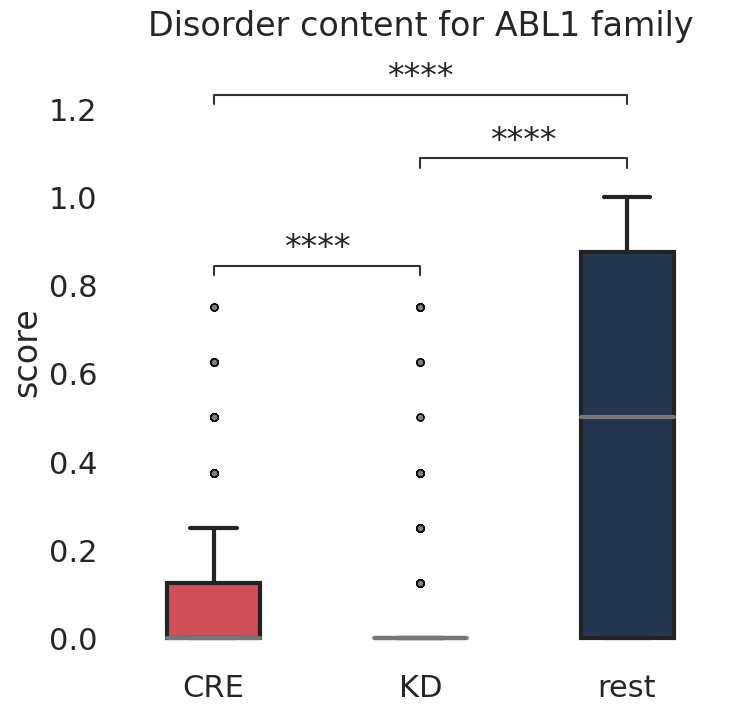

In [52]:
plot_disorder(msa_name= "P00519_60", dataset= mobidb_lite_cre_msa, title= "Disorder content for ABL1 family", out= '../plots/paper/abl1_disorder_content')

/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CRE vs. KD: Mann-Whitney-Wilcoxon test two-sided, P_val:8.144e-40 U_stat=5.254e+06
KD vs. rest: Mann-Whitney-Wilcoxon test two-sided, P_val:4.663e-30 U_stat=2.539e+08
CRE vs. rest: Mann-Whitney-Wilcoxon test two-sided, P_val:1.619e-63 U_stat=2.344e+07


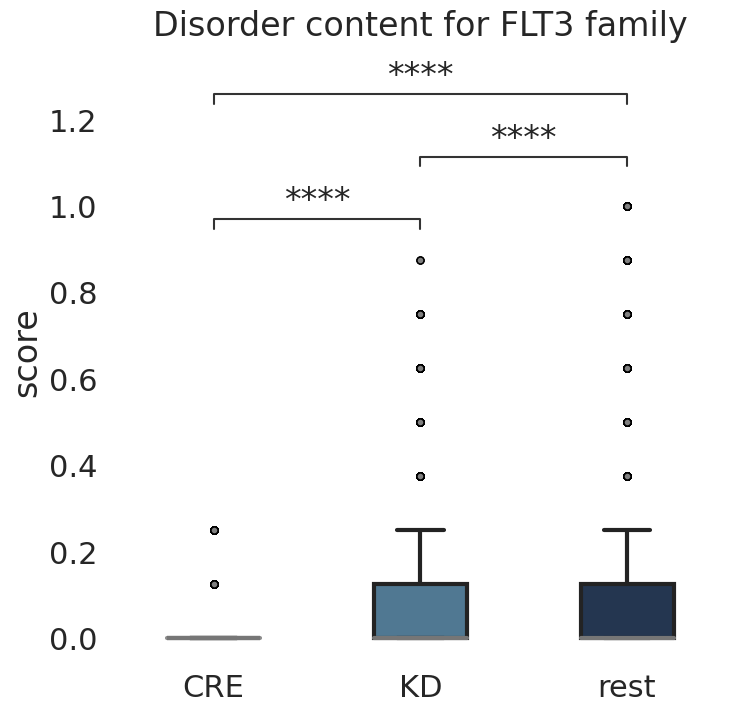

In [51]:
plot_disorder(msa_name= "P36888_60", dataset= mobidb_lite_cre_msa, title= "Disorder content for FLT3 family", out= '../plots/paper/flt3_disorder_content')

/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CRE vs. KD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.015e-126 U_stat=2.772e+07
KD vs. rest: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.194e+09
CRE vs. rest: Mann-Whitney-Wilcoxon test two-sided, P_val:1.174e-264 U_stat=6.328e+07


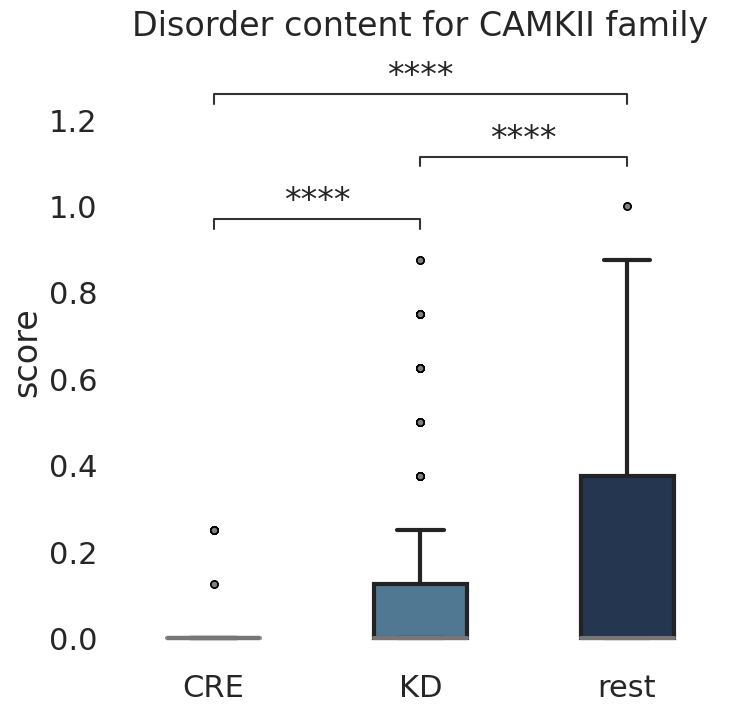

In [17]:
plot_disorder(msa_name= "Q13557_60", dataset= mobidb_lite_cre_msa, title= "Disorder content for CAMKII family", out= '../plots/paper/camkii_disorder_content')

/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CRE vs. KD: Mann-Whitney-Wilcoxon test two-sided, P_val:8.500e-01 U_stat=1.388e+07
KD vs. rest: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.201e+08
CRE vs. rest: Mann-Whitney-Wilcoxon test two-sided, P_val:5.085e-126 U_stat=1.768e+07


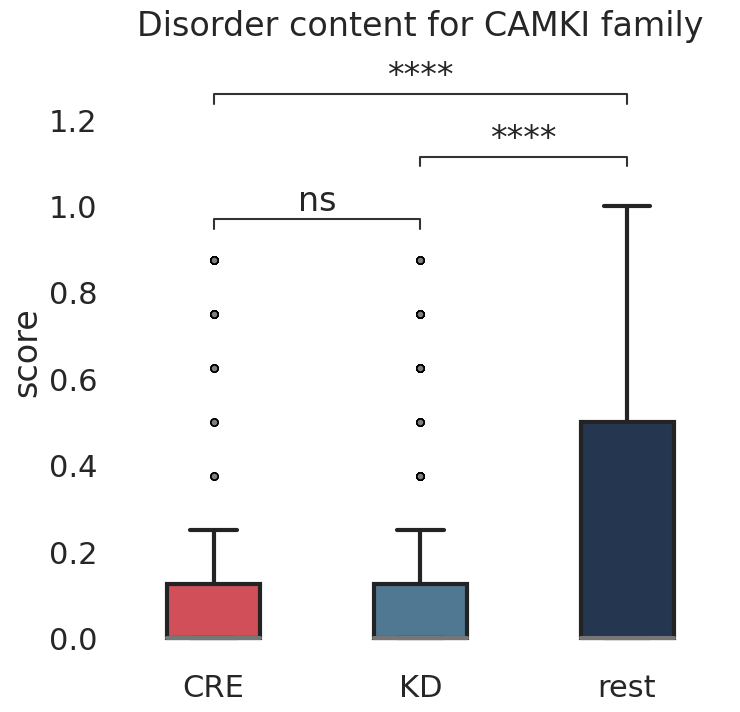

In [19]:
plot_disorder(msa_name= "Q91YS8_60", dataset= mobidb_lite_cre_msa, title= "Disorder content for CAMKI family", out= '../plots/paper/camki_disorder_content')

# Secondary structure

In [25]:
all_msas = pd.read_csv('../datasets/all_msas.tsv', sep= '\t')
all_msas = all_msas[all_msas.msa.str.endswith("60")]
all_msas.drop(columns= 'length_msa', inplace= True)

In [53]:
# Ver
#pd.read_csv('../homology_transfer/pipeline_MSA_uniprot/data_snake/12_region_to_transfer.txt', sep= " ")

In [26]:
regions = pd.read_csv('../datasets/regions.txt', sep= "\t")
kds = regions[regions.term_id.str.startswith("kd")].rename(columns= {'start': 'start_kd', 'end': 'end_kd'}).rename(columns= {'uniprot_acc': 'uniprot'})
cres = regions[regions.term_id.str.startswith("cre")].rename(columns= {'start': 'start_cre', 'end': 'end_cre'}).rename(columns= {'uniprot_acc': 'uniprot'})
regions_h = kds.merge(cres, left_on= 'uniprot', right_on= 'uniprot').rename(columns= {'term_id_x': 'kd_id', 'term_id_y': 'cre_id'})
regions_h

,uniprot,start_kd,end_kd,kd_id,start_cre,end_cre,cre_id
0,A0A2I0BVG8,56,325,kd1,346,353,cre1
1,A0A509AFG4,110,365,kd2,385,393,cre2
2,A0A509AHB6,57,324,kd3,345,352,cre3
3,A0A509AKL0,545,802,kd4,1,33,cre4
4,A0A509AQE6,118,372,kd5,394,402,cre5
...,...,...,...,...,...,...,...
288,Q9ZSA4,28,290,kd282,295,325,cre282
289,Q9ZUZ2,143,405,kd283,409,439,cre283
290,Q9ZV15,134,392,kd284,398,428,cre284
291,W0LYS5,31,287,kd285,287,327,cre285


In [27]:
regions = all_msas.merge(regions_h)
regions = regions.rename(columns= {'uniprot': 'uniprot_acc'})
regions

,msa,uniprot_acc,start_kd,end_kd,kd_id,start_cre,end_cre,cre_id
0,A0A2I0BVG8_60,A0A2I0BVG8,56,325,kd1,346,353,cre1
1,A0A509AFG4_60,A0A509AFG4,110,365,kd2,385,393,cre2
2,A0A509AHB6_60,A0A509AHB6,57,324,kd3,345,352,cre3
3,A0A509AKL0_60,A0A509AKL0,545,802,kd4,1,33,cre4
4,A0A509AQE6_60,A0A509AQE6,118,372,kd5,394,402,cre5
...,...,...,...,...,...,...,...,...
348,Q9ZSA2_60,Q9ZSA2,80,338,kd280,343,373,cre280
349,Q9ZSA3_60,Q9ZSA3,36,305,kd281,309,339,cre281
350,Q9ZUZ2_60,Q9ZUZ2,143,405,kd283,409,439,cre283
351,Q9ZV15_60,Q9ZV15,134,392,kd284,398,428,cre284


In [28]:
mobidb_secondary_scores = pd.read_csv('../datasets/mobidb_secondary_scores.tsv', sep= '\t') # , dtype= {'score_helix_fess': list, 'score_sheet_fess': list, 'score_coil_fess': list}
mobidb_secondary_scores.rename(columns= {'uniprot_acc': 'uniprot'}, inplace= True)
# Set scores columns as list type
mobidb_secondary_scores.score_helix_fess = mobidb_secondary_scores.score_helix_fess.apply(lambda x: eval(x))
mobidb_secondary_scores.score_sheet_fess = mobidb_secondary_scores.score_sheet_fess.apply(lambda x: eval(x))
mobidb_secondary_scores.score_coil_fess = mobidb_secondary_scores.score_coil_fess.apply(lambda x: eval(x))
mobidb_secondary_scores.rename(columns= {'uniprot': 'uniprot_acc'}, inplace= True)

In [29]:
scores_df = regions.merge(mobidb_secondary_scores)

In [30]:
scores_df.msa.nunique()

250

In [13]:
prueba = cre_coordinates.merge(all_msas.rename(columns= {'uniprot': 'uniprot_acc'}), how= 'left')
prueba

,uniprot_acc,term_id,start,end,is_reference,msa
0,A0A2I0BVG8,cre1,346,353,True,A0A2I0BVG8_60
1,A0A509AFG4,cre2,385,393,True,A0A509AFG4_60
2,A0A509AHB6,cre3,345,352,True,A0A509AHB6_60
3,A0A509AQE6,cre5,394,402,True,A0A509AQE6_60
4,A0A5K1K8H0,cre6,400,408,True,A0A5K1K8H0_60
...,...,...,...,...,...,...
48478,A0A0D9QPF1,kd286,541,798,False,W7JX98_60
48479,A0A0L7M3I6,kd286,541,798,False,A0A509AKL0_60
48480,A0A0L7M3I6,kd286,541,798,False,A5K0N4_60
48481,A0A0L7M3I6,kd286,541,798,False,Q8I719_60


In [14]:
prueba[['msa', 'uniprot_acc']].drop_duplicates()

,msa,uniprot_acc
0,A0A2I0BVG8_60,A0A2I0BVG8
1,A0A509AFG4_60,A0A509AFG4
2,A0A509AHB6_60,A0A509AHB6
3,A0A509AQE6_60,A0A509AQE6
4,A0A5K1K8H0_60,A0A5K1K8H0
...,...,...
48394,Q9ZV15_60,V7BII1
48399,Q9ZV15_60,A0A803QIA2
48402,Q9ZV15_60,A0A087H3U3
48403,Q9ZV15_60,I1L9Q2


In [15]:
# Add scores
prueba = prueba.merge(mobidb_secondary_scores)

In [16]:
prueba

,uniprot_acc,term_id,start,end,is_reference,msa,length,score_helix_fess,score_sheet_fess,score_coil_fess
0,A0A2I0BVG8,cre1,346,353,True,A0A2I0BVG8_60,524,"[0.003, 0.027, 0.055, 0.079, 0.165, 0.187, 0.2...","[0.002, 0.096, 0.165, 0.182, 0.168, 0.139, 0.1...","[0.995, 0.877, 0.78, 0.739, 0.667, 0.674, 0.66..."
1,A0A509AFG4,cre2,385,393,True,A0A509AFG4_60,554,"[0.003, 0.122, 0.2, 0.225, 0.231, 0.256, 0.248...","[0.002, 0.102, 0.342, 0.431, 0.487, 0.497, 0.4...","[0.995, 0.776, 0.459, 0.344, 0.282, 0.247, 0.3..."
2,A0A509AHB6,cre3,345,352,True,A0A509AHB6_60,523,"[0.003, 0.03, 0.077, 0.103, 0.187, 0.17, 0.183...","[0.002, 0.086, 0.153, 0.151, 0.166, 0.168, 0.1...","[0.995, 0.884, 0.77, 0.746, 0.647, 0.661, 0.64..."
3,A0A509AQE6,cre5,394,402,True,A0A509AQE6_60,562,"[0.003, 0.074, 0.148, 0.215, 0.224, 0.209, 0.1...","[0.002, 0.181, 0.235, 0.237, 0.234, 0.188, 0.1...","[0.994, 0.745, 0.617, 0.549, 0.542, 0.603, 0.7..."
4,A0A5K1K8H0,cre6,400,408,True,A0A5K1K8H0_60,568,"[0.003, 0.046, 0.186, 0.202, 0.253, 0.318, 0.3...","[0.002, 0.114, 0.209, 0.251, 0.323, 0.325, 0.3...","[0.995, 0.84, 0.605, 0.548, 0.424, 0.357, 0.37..."
...,...,...,...,...,...,...,...,...,...,...
48478,A0A087H3U3,cre284,347,377,False,Q9ZV15_60,646,"[0.003, 0.08, 0.259, 0.292, 0.459, 0.489, 0.53...","[0.003, 0.04, 0.061, 0.081, 0.082, 0.113, 0.20...","[0.994, 0.88, 0.679, 0.627, 0.459, 0.398, 0.26..."
48479,I1L9Q2,kd284,149,407,False,Q9ZV15_60,595,"[0.003, 0.027, 0.058, 0.058, 0.043, 0.035, 0.0...","[0.003, 0.073, 0.112, 0.202, 0.292, 0.295, 0.2...","[0.994, 0.9, 0.83, 0.74, 0.665, 0.67, 0.757, 0..."
48480,I1L9Q2,cre284,413,443,False,Q9ZV15_60,595,"[0.003, 0.027, 0.058, 0.058, 0.043, 0.035, 0.0...","[0.003, 0.073, 0.112, 0.202, 0.292, 0.295, 0.2...","[0.994, 0.9, 0.83, 0.74, 0.665, 0.67, 0.757, 0..."
48481,A0A2R6RA28,kd284,150,408,False,Q9ZV15_60,599,"[0.003, 0.026, 0.033, 0.039, 0.03, 0.029, 0.03...","[0.002, 0.091, 0.184, 0.378, 0.447, 0.421, 0.2...","[0.995, 0.883, 0.783, 0.583, 0.523, 0.55, 0.69..."


In [31]:
# Secondary structure scor boxplots with statistics
# palette: https://coolors.co/palette/ef476f-ffd166-06d6a0-118ab2-073b4c
# annotator: https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00

summary = pd.DataFrame() # columns= ['msa', 'element', 'feature', 'median_score', 'mean_score']

for msa, df in scores_df.groupby('msa'):
    
    helix = df[['msa', 'score_helix_fess']].explode('score_helix_fess')
    helix["pos"] = [ i+1 for i in range(len(helix)) ]
    helix["element"] = "H"
    helix = helix.rename(columns= {'score_helix_fess': 'score'}).reset_index(drop= True)
    # Add feature name based on coordinates
    helix["feature"] = 'rest' # all that is not CRE nor KD
    helix.loc[((helix.pos >= df.start_cre.values[0]) & (helix.pos <= df.end_cre.values[0])), "feature"] = 'CRE'
    helix.loc[((helix.pos >= df.start_kd.values[0]) & (helix.pos <= df.end_kd.values[0])), "feature"] = 'KD'


    sheet = df[['msa', 'score_sheet_fess']].explode('score_sheet_fess')
    sheet["pos"] = [ i+1 for i in range(len(sheet)) ]
    sheet["element"] = "E"
    sheet = sheet.rename(columns= {'score_sheet_fess': 'score'}).reset_index(drop= True)
    # Add feature name based on coordinates
    sheet["feature"] = 'rest' # all that is not CRE nor KD
    sheet.loc[((sheet.pos >= df.start_cre.values[0]) & (sheet.pos <= df.end_cre.values[0])), "feature"] = 'CRE'
    sheet.loc[((sheet.pos >= df.start_kd.values[0]) & (sheet.pos <= df.end_kd.values[0])), "feature"] = 'KD'


    coil = df[['msa', 'score_coil_fess']].explode('score_coil_fess')
    coil["pos"] = [ i+1 for i in range(len(coil)) ]
    coil["element"] = "C"
    coil = coil.rename(columns= {'score_coil_fess': 'score'}).reset_index(drop= True)
    # Add feature name based on coordinates
    coil["feature"] = 'rest' # all that is not CRE nor KD
    coil.loc[((coil.pos >= df.start_cre.values[0]) & (coil.pos <= df.end_cre.values[0])), "feature"] = 'CRE'
    coil.loc[((coil.pos >= df.start_kd.values[0]) & (coil.pos <= df.end_kd.values[0])), "feature"] = 'KD'

    df_scores = pd.concat([helix, sheet, coil])

    # # For each MSA, store the means and medians
    # for feature, group in df_scores.groupby("feature"):
    #     entry = pd.DataFrame(data = {'msa': msa, 'feature': feature, 'median_score':  group.score.median(), 'mean_score': group.score.mean() }, index= [0] )
    #     summary = pd.concat([summary, entry])

    # For each MSA, store the means and medians
    to_concat = pd.DataFrame()
    for (element, feature), group in df_scores.groupby(["element", "feature"]):
        #print(element, feature)
        entry = pd.DataFrame(data = {'msa': msa, 'feature': feature, 'element': element, 'median_score':  group.score.median(), 'mean_score': group.score.mean() }, index= [0] )
        to_concat = pd.concat([to_concat, entry])
        summary = pd.concat([summary, to_concat])
    

    # # Plot
    # colors= ["#EF476F", "#06D6A0", "#118AB2"]
    # sns.set(rc={'figure.figsize':(10, 8)}, font_scale= 2)

    # flierprops = dict(marker='o', markerfacecolor='gray', markersize= 5,  markeredgecolor='black')
    # ax = sns.boxplot(data= df_scores, x= 'feature', y= 'score', hue= 'element', order= ['CRE', 'KD', 'rest'], width= 0.45, linewidth= 3, medianprops=dict(color="gray", alpha=0.9), palette= colors, flierprops= flierprops) # , showmeans= True, meanline= True , notch= True , showmeans= True, meanline= True

    # # Combinations to compare
    # comb = combinations(scores_df.feature.unique(), 2)
    # pairs = [ i for i in comb ]

    # annotator = Annotator(ax= ax, pairs= pairs, data= summary, x= 'feature', y= 'median_score')
    # annotator.configure(test= 'Mann-Whitney', text_format='star')
    # annotator.apply_and_annotate()

    #plt.rcParams['font.size'] = 16
    # plt.title(f"Secondary structure content for msa {msa}")
    # plt.ylabel("Fells score")
    # plt.xlabel("")
    # plt.legend(loc= 1, bbox_to_anchor=(1.20, 1))
    # plt.tight_layout()
    # plt.savefig(f'../plots/secondary_structure/by_msa/{msa}.png', dpi= 200)
    # plt.show()

In [32]:
summary

,msa,feature,element,median_score,mean_score
0,A0A2I0BVG8_60,CRE,C,0.3625,0.372750
0,A0A2I0BVG8_60,CRE,C,0.3625,0.372750
0,A0A2I0BVG8_60,KD,C,0.3020,0.347322
0,A0A2I0BVG8_60,CRE,C,0.3625,0.372750
0,A0A2I0BVG8_60,KD,C,0.3020,0.347322
...,...,...,...,...,...
0,W7JX98_60,KD,E,0.1820,0.242930
0,W7JX98_60,rest,E,0.2340,0.308461
0,W7JX98_60,CRE,H,0.2890,0.279655
0,W7JX98_60,KD,H,0.2675,0.365694


### Plots

In [33]:
def plot_ss(msa_name, title, stats= False, out= None):
    
    df = scores_df[scores_df.msa == msa_name]

    helix = df[['msa', 'score_helix_fess']].explode('score_helix_fess')
    helix["pos"] = [ i+1 for i in range(len(helix)) ]
    helix["element"] = "H"
    helix = helix.rename(columns= {'score_helix_fess': 'score'}).reset_index(drop= True)
    # Add feature name based on coordinates
    helix["feature"] = 'rest' # all that is not CRE nor KD
    helix.loc[((helix.pos >= df.start_cre.values[0]) & (helix.pos <= df.end_cre.values[0])), "feature"] = 'CRE'
    helix.loc[((helix.pos >= df.start_kd.values[0]) & (helix.pos <= df.end_kd.values[0])), "feature"] = 'KD'


    sheet = df[['msa', 'score_sheet_fess']].explode('score_sheet_fess')
    sheet["pos"] = [ i+1 for i in range(len(sheet)) ]
    sheet["element"] = "E"
    sheet = sheet.rename(columns= {'score_sheet_fess': 'score'}).reset_index(drop= True)
    # Add feature name based on coordinates
    sheet["feature"] = 'rest' # all that is not CRE nor KD
    sheet.loc[((sheet.pos >= df.start_cre.values[0]) & (sheet.pos <= df.end_cre.values[0])), "feature"] = 'CRE'
    sheet.loc[((sheet.pos >= df.start_kd.values[0]) & (sheet.pos <= df.end_kd.values[0])), "feature"] = 'KD'


    coil = df[['msa', 'score_coil_fess']].explode('score_coil_fess')
    coil["pos"] = [ i+1 for i in range(len(coil)) ]
    coil["element"] = "C"
    coil = coil.rename(columns= {'score_coil_fess': 'score'}).reset_index(drop= True)
    # Add feature name based on coordinates
    coil["feature"] = 'rest' # all that is not CRE nor KD
    coil.loc[((coil.pos >= df.start_cre.values[0]) & (coil.pos <= df.end_cre.values[0])), "feature"] = 'CRE'
    coil.loc[((coil.pos >= df.start_kd.values[0]) & (coil.pos <= df.end_kd.values[0])), "feature"] = 'KD'

    df_scores = pd.concat([helix, sheet, coil]) 

    # Plot
    colors= ["#EF476F", "#06D6A0", "#118AB2"]
    sns.set(rc={'figure.figsize':(10, 8)}, font_scale= 2)

    flierprops = dict(marker='o', markerfacecolor='gray', markersize= 5,  markeredgecolor='black')
    ax = sns.boxplot(data= df_scores, x= 'feature', y= 'score', hue= 'element', order= ['CRE', 'KD', 'rest'], width= 0.45, linewidth= 3, medianprops=dict(color="gray", alpha=0.9), palette= colors, flierprops= flierprops) # , showmeans= True, meanline= True , notch= True , showmeans= True, meanline= True

    # # Combinations to compare
    # comb = combinations(df_scores.feature.unique(), 2)
    # pairs = [ i for i in comb ]

    # annotator = Annotator(ax= ax, pairs= pairs, data= df_scores, x= 'feature', y= 'score')
    # annotator.configure(test= 'Mann-Whitney', text_format='star')
    # annotator.apply_and_annotate()

    plt.rcParams['font.size'] = 16
    plt.title(title)
    plt.ylabel("score")
    plt.xlabel("")
    plt.legend(loc= 1, bbox_to_anchor=(1.20, 1))
    plt.tight_layout()

    if out != None:

        plt.savefig(f'{out}.png', dpi= 300)
    plt.show()

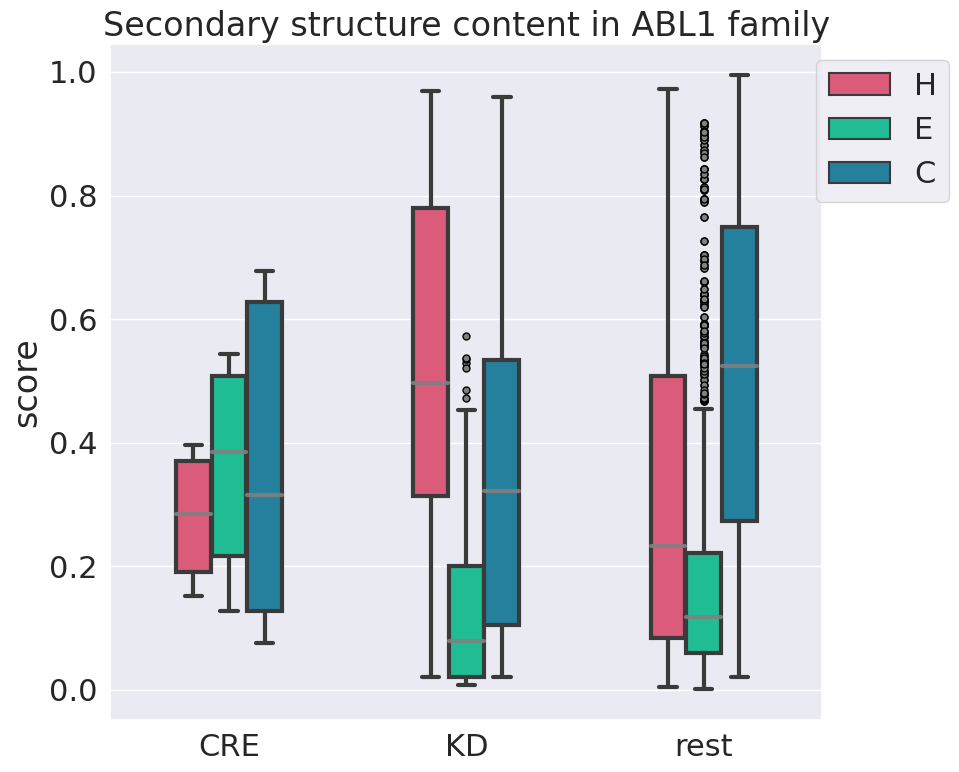

In [86]:
plot_ss(msa_name= "P00519_60", title= "Secondary structure content in ABL1 family", out= '../plots/paper/abl1_secondary_structure')

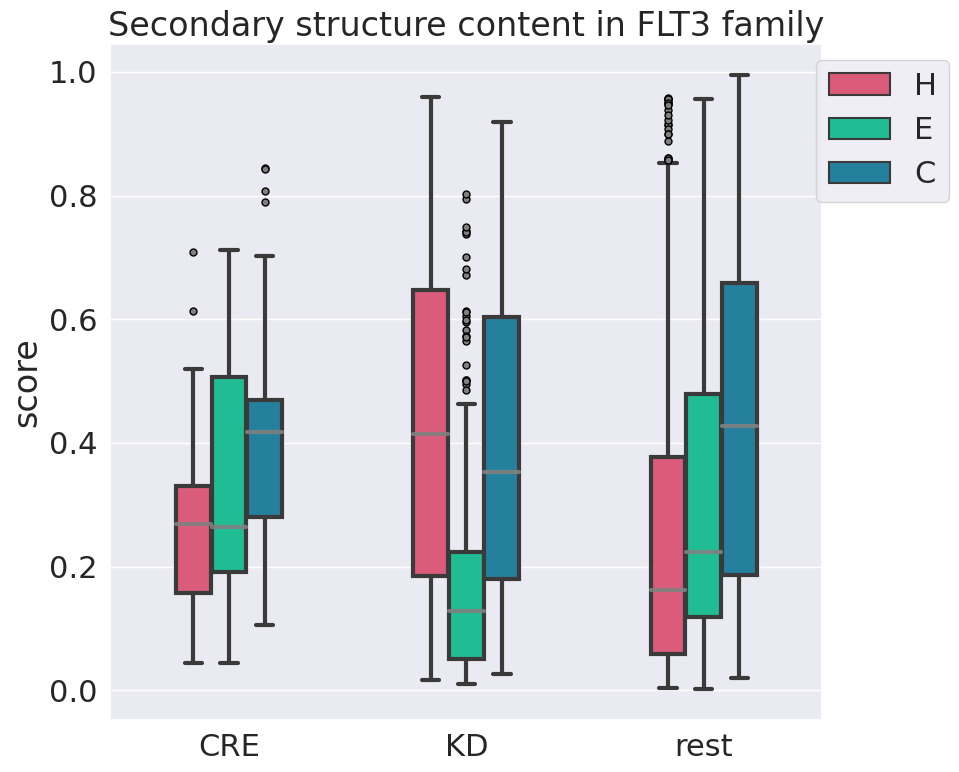

In [20]:
plot_ss(msa_name= 'P36888_60', title= "Secondary structure content in FLT3 family", out= '../plots/paper/flt3_secondary_structure')

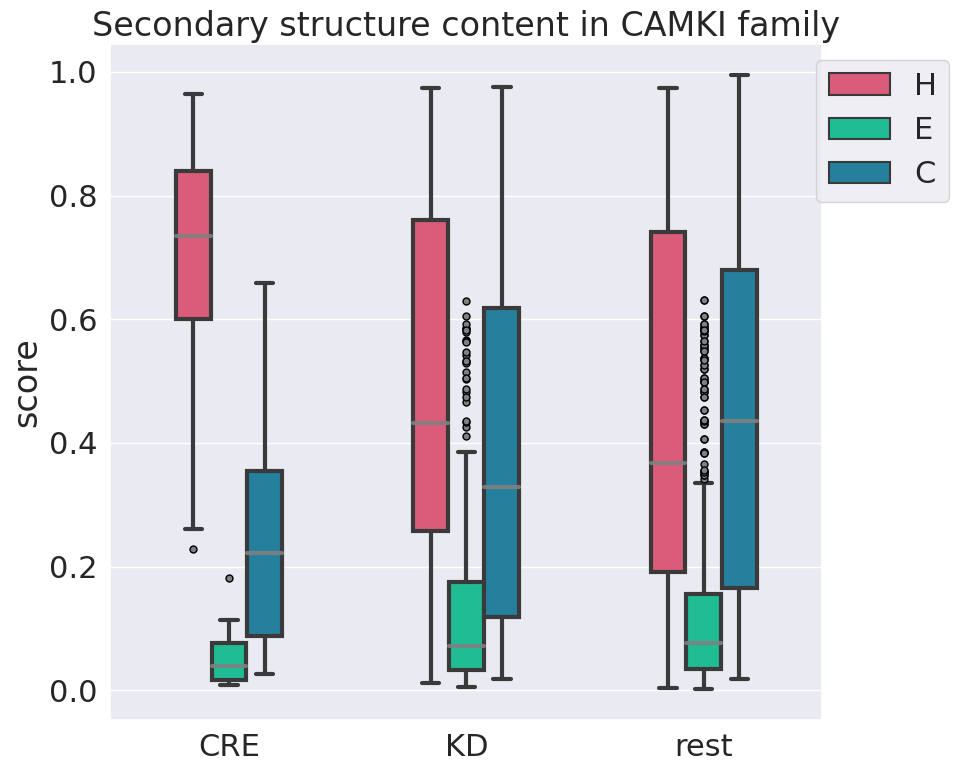

In [34]:
plot_ss(msa_name= 'Q91YS8_60', title= "Secondary structure content in CAMKI family", out= '../plots/paper/camki_secondary_structure')

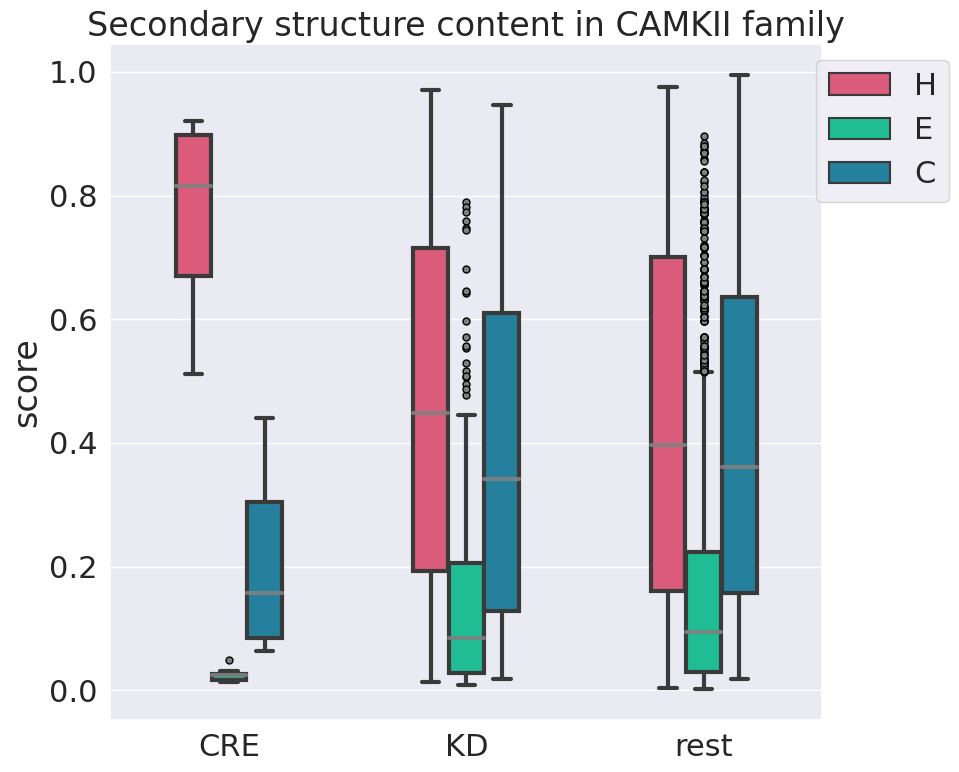

In [45]:
plot_ss(msa_name= 'Q13557_60', title= "Secondary structure content in CAMKII family", out= '../plots/paper/camkii_secondary_structure')

In [74]:
df_scores

,msa,score,pos,element,feature
0,W7JX98_60,0.003,1,H,CRE
1,W7JX98_60,0.112,2,H,CRE
2,W7JX98_60,0.352,3,H,CRE
3,W7JX98_60,0.401,4,H,CRE
4,W7JX98_60,0.49,5,H,CRE
...,...,...,...,...,...
848,W7JX98_60,0.68,849,C,rest
849,W7JX98_60,0.646,850,C,rest
850,W7JX98_60,0.677,851,C,rest
851,W7JX98_60,0.765,852,C,rest


In [78]:
df_scores[['feature', 'element']]#.unique()

,feature,element
0,CRE,H
1,CRE,H
2,CRE,H
3,CRE,H
4,CRE,H
...,...,...
848,rest,C
849,rest,C
850,rest,C
851,rest,C


In [80]:
comb = combinations(df_scores.element.unique(), 2)
pairs = [ i for i in comb ]
pairs

[('H', 'E'), ('H', 'C'), ('E', 'C')]